In [1]:
import sys, os
import qp
import numpy as np
from scipy import linalg as sla
from scipy import special
from scipy import integrate as sciint
from scipy import interpolate as sciinterp
from matplotlib import pylab as plt
from astropy.io import fits as pf
%matplotlib inline
%config Completer.use_jedi = False

We load the data : pdf examples from either qp or the original SparsePz package

In [2]:
Ntot = 10 #limit the number of pdfs for testing. Set to -1 to load all pdfs
if True:
    filein = '/home/cohen/lsst/codes/pipelines/photoz/SparsePz/CFHTLens_sample.P.npy'
    #FORMAT FILE, EACH ROW IS THE PDF FOR EACH GALAXY, LAST ROW IS THE REDSHIFT POSITION
    P = np.load(filein)
    z = P[-1]
    P = P[:Ntot]
else:
    ens = qp.read('qp_test_ensemble.hdf5')
    z = ens.metadata()['xvals'][0]
    if Ntot != -1:
        ens_red = ens[np.arange(Ntot)]
    else:
        ens_red = ens
    P = ens_red.objdata()['yvals']

We want to enforce normalisation, just in case the input pdfs are not properly normalized, and we want to optimize the grid used for sparse representation over the whole considered sample (the same grid needs to be used for every pdf in the sample). We use trapezoidal rule as a fast integrator and likely a sufficient precision for our purpose.

In [3]:
P = P/sciint.trapz(P,z).reshape(-1,1)

In [4]:
minz = np.min(z)
nz = 300
i,j=np.where(P>0)
maxz=np.max(z[j])
newz=np.linspace(minz, maxz, nz)
interp = sciinterp.interp1d(z,P, assume_sorted=True)
newpdf = interp(newz)
newpdf = newpdf / sciint.trapz(newpdf,newz).reshape(-1,1)

In [5]:
##check the pdfs if the Ntot is not too large
#plt.plot(z,P.T); plt.plot(newz,newpdf.T,'.'); plt.xlim(minz,maxz);

The following call builds the sparse representation:

In [6]:
ALL, bigD = qp.utils.build_sparse_representation(newz, newpdf)

Total Galaxies =  10
dz =  0.005810066889632109
Nmu, Nsig, Nv =  [ 300 , 50 , 3 ]
Total bases in dictionary 45000
Creating Dictionary...
Nsparse (number of bases) =  20
Creating Sparse representation...
done


Now, we use this representation to reconstruct a pdf, and compare to the original one. It is important to note that the sparse representation is *not* a functional representation : one need to start with the grid representation embedded in the sparse representation and interpolate, if one wants to use an arbitrary array of x values for subsequent use.

In [7]:
#Next decode the sparse indices into the voigt shape parameters
va, ma, sa, ga = qp.utils.indices2shapes(ALL, bigD)
#va, ma, sa, ga = indices2shapes(ALL, meta)

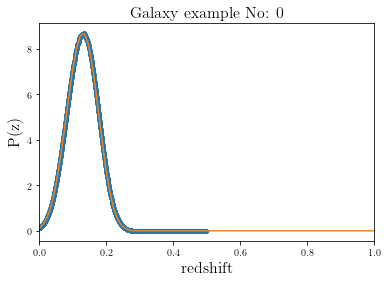

In [18]:
k=0
cut=1.e-5
#this is the original grid, needed here to plot the original pdf
z = bigD['z']
#Choose a new grid to evaluate the PDF
newz = np.linspace(0,0.5,5000)
pdf = np.zeros_like(newz)
for v, m, s, g in zip(va[k],ma[k],sa[k],ga[k]):
    pdft = special.voigt_profile(newz - m, s, g)
    pdft = np.where(pdft >= cut, pdft, 0.)
    pdft = v * pdft / sla.norm(pdft)
    pdf += pdft
pdf = pdf / sciint.trapz(pdf,newz)
#plt.plot(newz,pdf-newpdf[k],'r', linewidth=2)
plt.plot(newz,pdf,'.', linewidth=2)
plt.plot(z,newpdf[k], '-')
plt.xlim(0,1)
title = 'Galaxy example No: %d' % k
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.title(title);


In [ ]:
#writing to a fits file, as originally proposed in SparsePz
if False:
    print('Writing fits file (example_out.fits)')

    head = pf.Header()
    head['N_TOT'] = Ntot
    head['N_MU'] = bigD['dims'][0]
    head['N_SIGMA'] = bigD['dims'][1]
    head['N_VOIGT'] = bigD['dims'][2]
    head['N_COEF'] = bigD['dims'][3]
    head['N_SPARSE'] = bigD['N_SPARSE']
    head['MU1'] = bigD['mu'][0]
    head['MU2'] = bigD['mu'][1]
    head['SIGMA1'] = bigD['sig'][0]
    head['SIGMA2'] = bigD['sig'][1]

    col1 = pf.Column(name='redshift', format='E', array=bigD['z'])
    fmt = '%dJ' % bigD['N_SPARSE']
    col2 = pf.Column(name='Sparse_indices', format=fmt, array=ALL)
    table1 = pf.BinTableHDU.from_columns(pf.ColDefs([col1]))
    table2 = pf.BinTableHDU.from_columns(pf.ColDefs([col2]))
    prihdu = pf.PrimaryHDU(header=head)
    hdulist = pf.HDUList([prihdu, table1, table2])
    hdulist.writeto('example_out.fits', overwrite=True)
